# Objectives
In this notebook we are going to create, evaluate and compare several models for forecasting product demand 

## WorkFlow

For this model we are going to do the following
1. Loading the product demand dataset 
2. Understanding the data for the 5 years 
3. Data cleaning
4. Trends Visualization 
5. Forecast modelling for several models and compare results
  - XGboost
  - ARIMA
  - SARIMA
  - Exponential Smoothing
  
  Evaluation Metrics
  - Mean Absolute Error
  - Mean Absolute Percentage Error
  - Root Mean Squared 
6. Select best performing model


## Load Data and Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("Historical Demand Data.csv")

## Understanding the Data 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9140 entries, 0 to 9139
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        9140 non-null   object
 1   Product_id  9140 non-null   object
 2   Demand      9140 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 214.3+ KB


In [4]:
data.head(20)

,Date,Product_id,Demand
0,2012-01-01,Product_001,3
1,2012-01-01,Product_002,1
2,2012-01-01,Product_003,3
3,2012-01-01,Product_004,3
4,2012-01-01,Product_005,7
5,2012-01-02,Product_001,7
6,2012-01-02,Product_002,2
7,2012-01-02,Product_003,9
8,2012-01-02,Product_004,9
9,2012-01-02,Product_005,4


In [5]:
data.shape

(9140, 3)

In [6]:
data.columns

Index(['Date', 'Product_id', 'Demand'], dtype='object')

In [7]:
# Count of Unique Product demand recorded
data["Product_id"].nunique()

5

In [8]:
# Product demand 
data["Product_id"].unique()

array(['Product_001', 'Product_002', 'Product_003', 'Product_004',
       'Product_005'], dtype=object)

- nunique() is a function used to return the number of unique values in a Series or DataFrame column.
- unique() returns an array or list of the unique values themselves.

In [9]:
# Average demand across years 
data["Demand"].mean()

17.673960612691467

In [10]:
data.describe()

,Demand
count,9140.000000
mean,17.673961
std,9.796141
min,0.000000
25%,10.000000
50%,16.000000
75%,24.000000
max,65.000000


- Average demand is 17.67
- Standard Deviation is 9.7 meaning that the values in the dataset typically differ from the mean (average) by about 9.7 units. It gives you an idea of the spread or dispersion of the data points around the mean.
- Median of demand is 16

## Data Cleaning 

In [11]:
# Check for missing values 
data.isna().sum()

Date          0
Product_id    0
Demand        0
dtype: int64

- There are no missing values 

In [12]:
# Checking earliest date recorded in the dataset
data["Date"].min()

'2012-01-01'

In [13]:
# Checking latest date recorded in the dataset
data["Date"].max()

'2017-01-01'

- This is a 5 year period dataset 

In [14]:
# Checking datatypes 
data.dtypes

Date          object
Product_id    object
Demand         int64
dtype: object

In [15]:
# Set the Date column as new index 
data = data.set_index("Date")
# Change the Date datatype (new index) into datetime 
data.index = pd.to_datetime(data.index)


In [16]:
data.dtypes

Product_id    object
Demand         int64
dtype: object

- This shows that Date is now an index and not a column and we are able to make visualization with ease 

In [17]:
data.head()

,Product_id,Demand
Date,,
2012-01-01,Product_001,3
2012-01-01,Product_002,1
2012-01-01,Product_003,3
2012-01-01,Product_004,3
2012-01-01,Product_005,7


## Trends Visualization/Exploratory Data Analysis

In [18]:
# Check color pallete 
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

<Axes: title={'center': 'Demand over 5 year Period'}, xlabel='Date'>

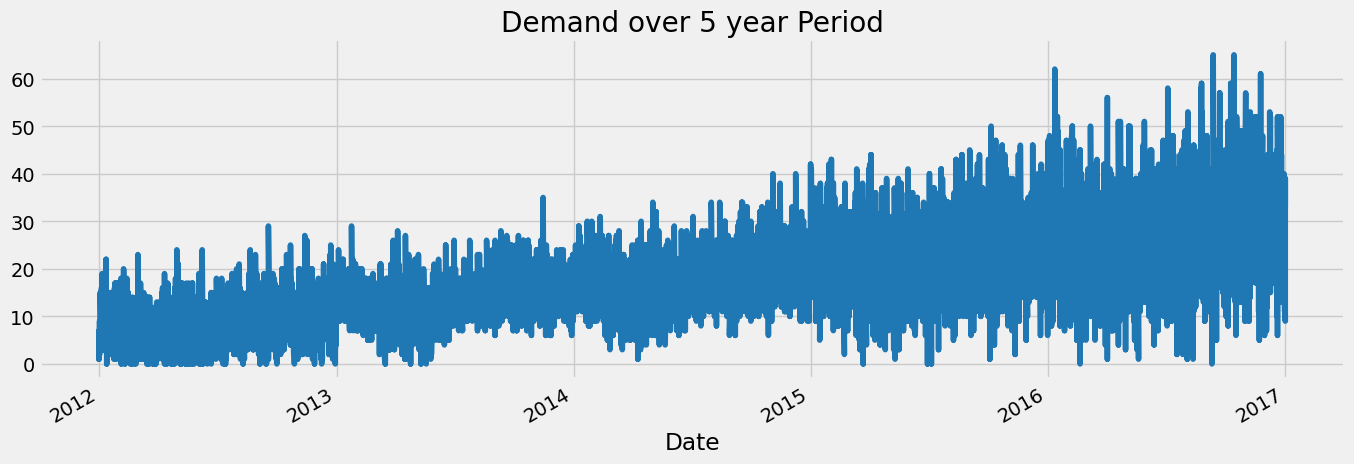

In [19]:
# Visualize demand across the years 
data["Demand"].plot(kind = "line", color = color_pal[0], figsize = (15,5), title = "Demand over 5 year Period")

1. Demand Trend:

- The graph shows an overall upward trend in demand from 2012 to 2017.
- The demand starts relatively low in 2012, with fluctuations around 10-20 units.
- From 2013 onwards, there is a gradual increase, and the spikes in demand become more pronounced.
- By 2016 and 2017, demand regularly exceeds 40 units and peaks above 60 units.
- This indicates that demand consistently increased over the 5-year period, with more variability and higher peaks in the later years.

2. Variance:

- Low variance is observed in the earlier years (2012-2013), where demand fluctuates within a smaller range (mostly under 20 units).
- As time progresses, variance increases. From 2014 onward, the demand fluctuations become more extreme, with both higher peaks and lower troughs.
- By 2016 and 2017, the variance is significantly higher, with frequent large spikes in demand, suggesting more irregular or seasonal demand patterns.
- The increase in variance reflects that demand became more unpredictable as time went on.

3. Seasonality or Cyclic Patterns:

- The graph suggests some seasonal or cyclic behavior—periods of rapid spikes followed by dips, particularly in later years.
- These patterns could correspond to seasonal factors affecting demand or market cycles that caused temporary increases or decreases in demand.

4. Key Observations:

- Gradual Increase: The general upward slope indicates that overall demand grew steadily.
- Increased Volatility: The variance in the later years (2016-2017) indicates more volatility in demand, which might suggest factors like market instability, seasonality, or external influences impacting demand fluctuations.

### Summary:
The graph shows a growing demand over time with an increasing variance. While demand steadily increases, the data also reflects more volatility and unpredictability in recent years, indicating possible external factors influencing demand spikes and troughs.

C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\2874532519.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[6], ax =axs[2,1], xlabel = "Monthly Demand across the Years")


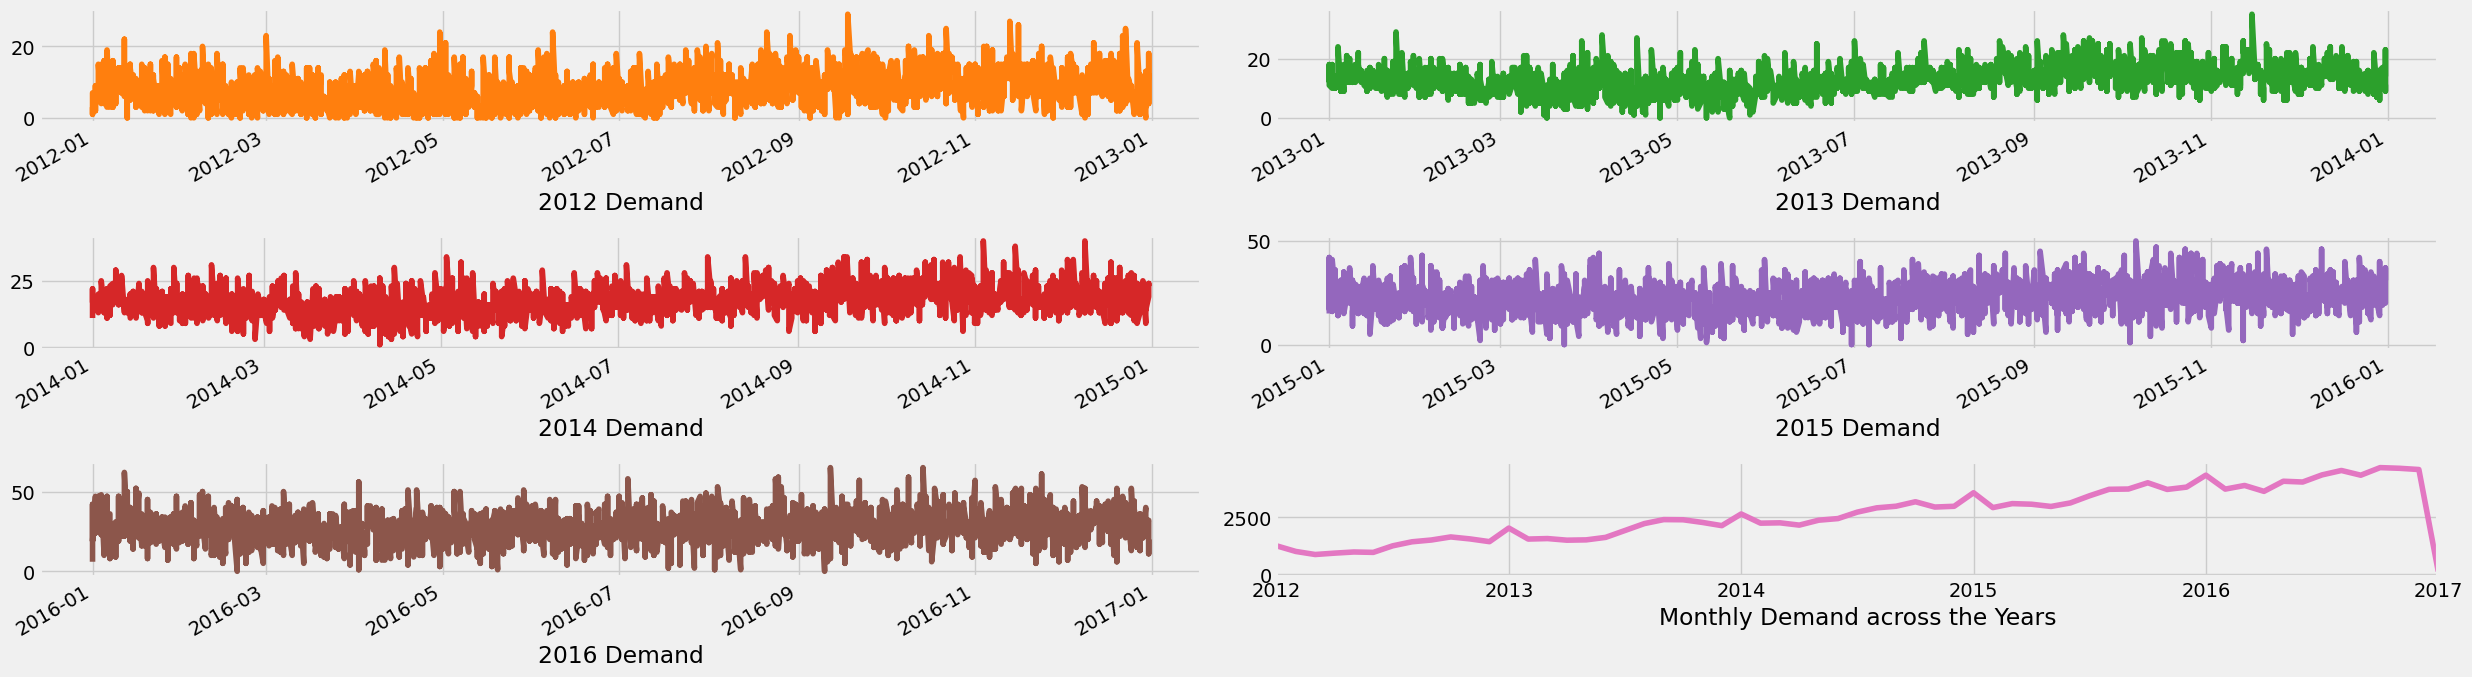

In [20]:
# Visualize each years data in subplots

# Create subplots
fig, axs = plt.subplots(3,2, figsize = (25, 7))

# Select data.plot(args)
data.loc[(data.index < "2013-01-01") & (data.index >= "2012-01-01")]["Demand"].plot(kind = "line", color = color_pal[1], ax =axs[0,0], xlabel = "2012 Demand")
data.loc[(data.index < "2014-01-01") & (data.index >= "2013-01-01")]["Demand"].plot(kind = "line", color = color_pal[2], ax =axs[0,1], xlabel = "2013 Demand")
data.loc[(data.index < "2015-01-01") & (data.index >= "2014-01-01")]["Demand"].plot(kind = "line", color = color_pal[3], ax =axs[1,0], xlabel = "2014 Demand")
data.loc[(data.index < "2016-01-01") & (data.index >= "2015-01-01")]["Demand"].plot(kind = "line", color = color_pal[4], ax =axs[1,1], xlabel = "2015 Demand")
data.loc[(data.index < "2017-01-01") & (data.index >= "2016-01-01")]["Demand"].plot(kind = "line", color = color_pal[5], ax =axs[2,0], xlabel = "2016 Demand")


data.resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[6], ax =axs[2,1], xlabel = "Monthly Demand across the Years")

# Adjusting layout and show
plt.tight_layout()
plt.show()


- 2012 Demand: Relatively low, with fluctuations mostly below 20 units.
- 2013 Demand: Slight increase compared to 2012, with demand still fluctuating around 20 units.
- 2014 Demand: Noticeable rise, with more frequent spikes, indicating higher variability.
- 2015 Demand: A clear increase in demand, with more fluctuations, often exceeding 25 units.
- 2016 Demand: The highest volatility and peaks, with values regularly going above 50 units.
- Monthly Demand Trend (bottom graph): Shows a steady upward trend in overall demand across years, peaking in 2016, with a sharp decline near the end of 2016/early 2017.
- In summary, demand gradually increased from 2012 to 2016, with more variance and volatility as the years progressed.

C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\4177696120.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.loc[(data.index < "2013-01-01") & (data.index >= "2012-01-01")].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[1], ax =axs[0,0], xlabel = "2012 Demand")
C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\4177696120.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.loc[(data.index < "2014-01-01") & (data.index >= "2013-01-01")].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[2], ax =axs[0,1], xlabel = "2013 Demand")
C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\4177696120.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.loc[(data.index < "2015-01-01") & (data.index >= "2014-01-01")].resample("M").sum()["Demand"].plot(kind

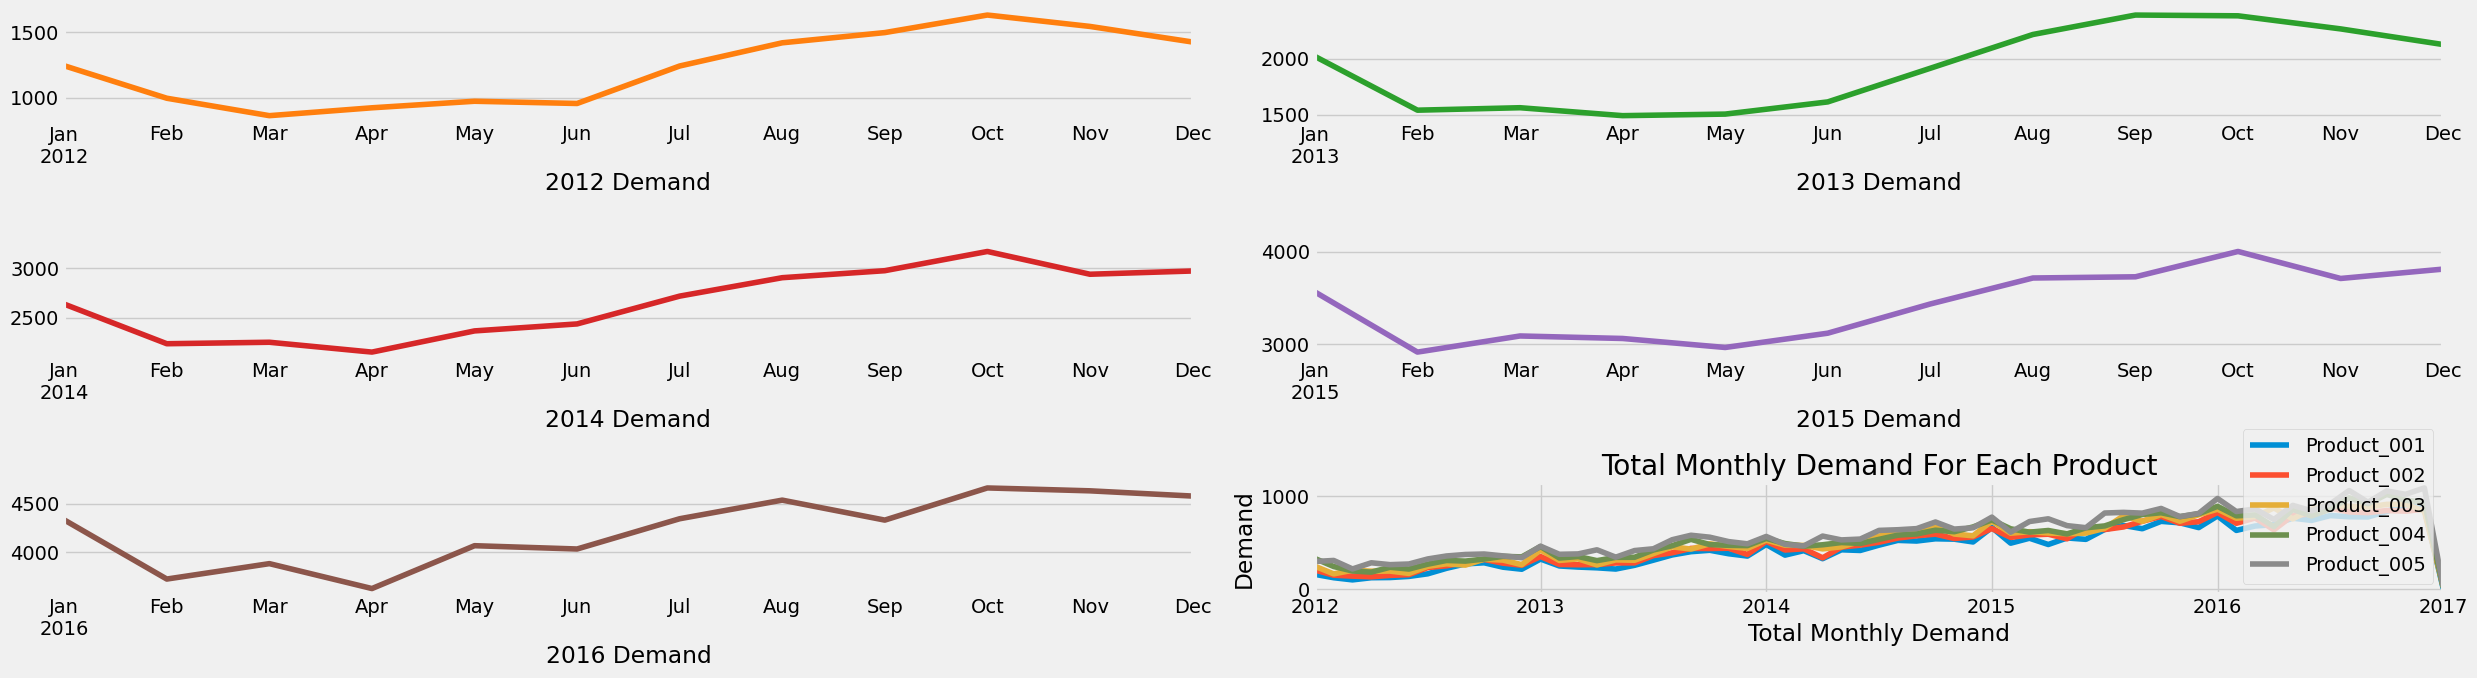

In [21]:
# Visualize each years monthly summed demand  

# Create subplots
fig, axs = plt.subplots(3,2, figsize = (25, 7))

# Select data.plot(args)
data.loc[(data.index < "2013-01-01") & (data.index >= "2012-01-01")].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[1], ax =axs[0,0], xlabel = "2012 Demand")
data.loc[(data.index < "2014-01-01") & (data.index >= "2013-01-01")].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[2], ax =axs[0,1], xlabel = "2013 Demand")
data.loc[(data.index < "2015-01-01") & (data.index >= "2014-01-01")].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[3], ax =axs[1,0], xlabel = "2014 Demand")
data.loc[(data.index < "2016-01-01") & (data.index >= "2015-01-01")].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[4], ax =axs[1,1], xlabel = "2015 Demand")
data.loc[(data.index < "2017-01-01") & (data.index >= "2016-01-01")].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[5], ax =axs[2,0], xlabel = "2016 Demand")




#iteratively select each product based on id
for product in data["Product_id"].unique():
    # Get total monthly demand values for each product
    product_monthly_demand = data[data["Product_id"] == product].resample("M").sum()["Demand"]
    product_monthly_demand.plot(kind ="line", ax =axs[2,1], label = product)

axs[2,1].set_xlabel("Total Monthly Demand")
axs[2,1].set_ylabel("Demand")
axs[2,1].set_title("Total Monthly Demand For Each Product")
axs[2,1].legend(loc = "lower right")

# Adjusting layout and show
plt.tight_layout()
plt.show()

- 2012 Demand: Peaks around mid-year (July-September) and declines towards the end of the year.
- 2013 Demand: Drops in the first few months but shows a steady increase from May, peaking around September.
- 2014 Demand: Gradual rise in demand after March, peaking in September and flattening out towards the end.
- 2015 Demand: Slight drop early in the year, followed by a gradual increase, peaking in September.
- 2016 Demand: Demand starts higher than previous years, dips in February, and gradually rises, peaking mid-year.
- Total Monthly Demand for Products (Bottom Graph): All products show a stable and consistent monthly demand trend, with no significant individual fluctuations.
- In general, demand across years shows a consistent pattern with peaks around mid-year and slight dips early in the year.








C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3800481298.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data[data["Product_id"] == "Product_001"].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[1], ax =axs[0,0], xlabel = "Product 001 Demand")
C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3800481298.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data[data["Product_id"] == "Product_002"].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[2], ax =axs[0,1], xlabel = "Product 002 Demand")
C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3800481298.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data[data["Product_id"] == "Product_003"].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[3], ax =axs[1,0], xlabel = "Product 00

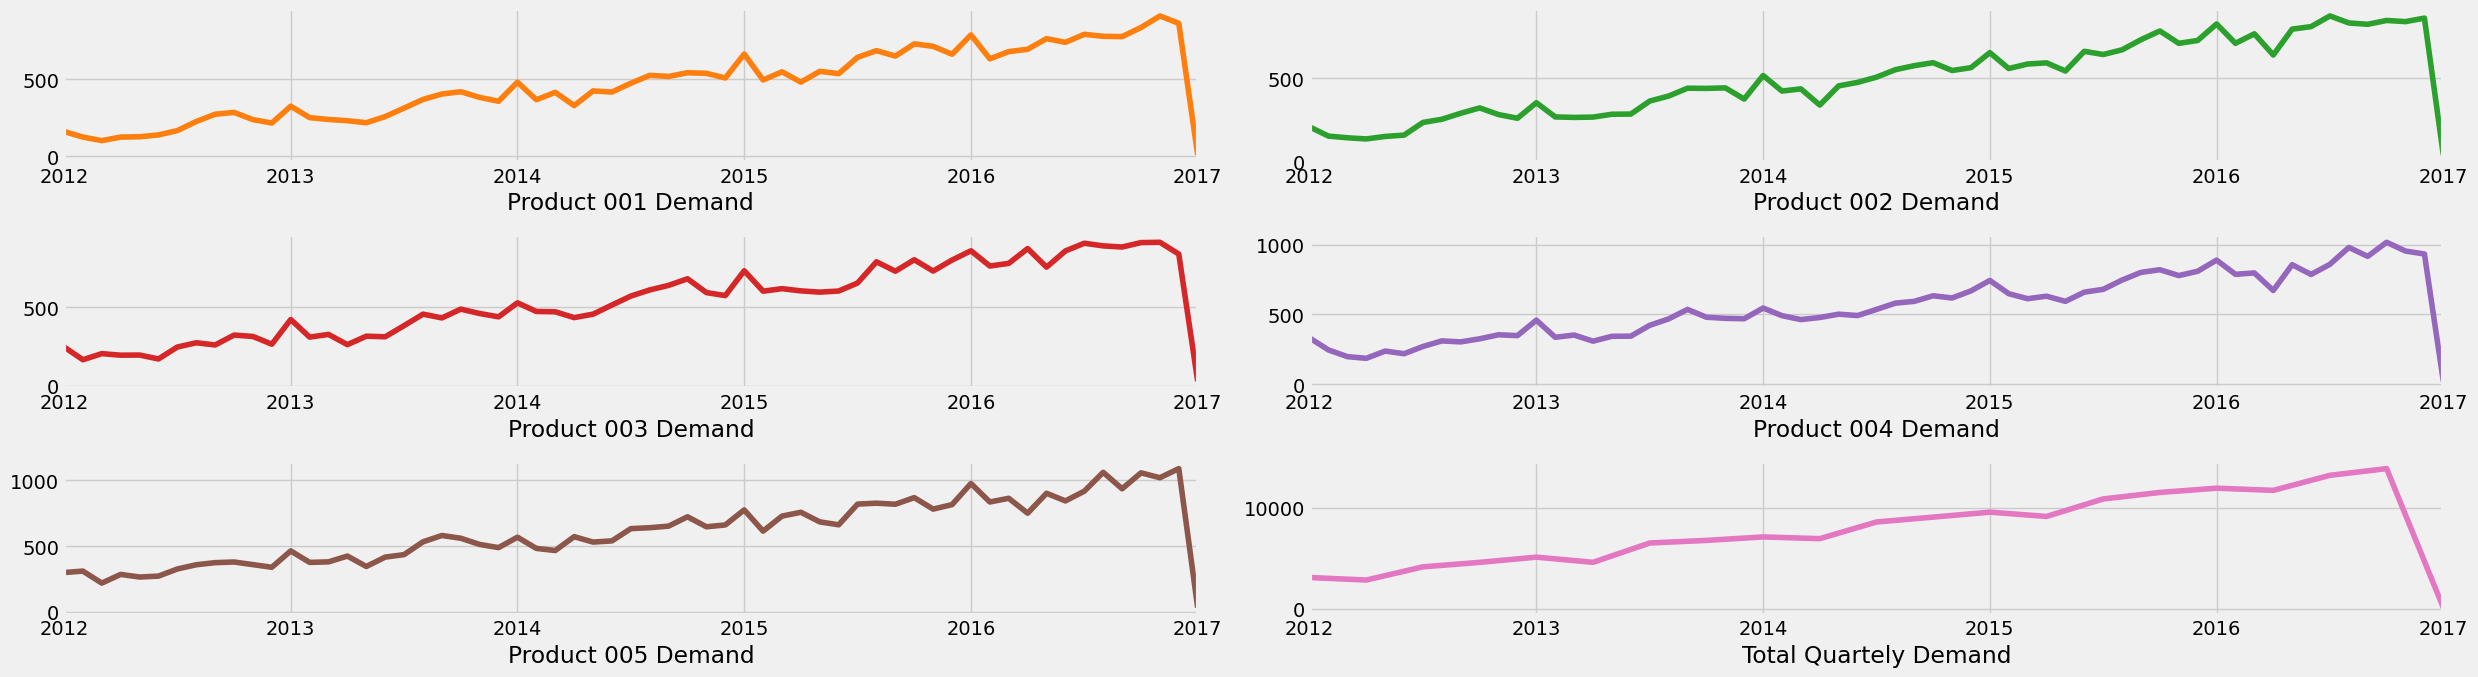

In [22]:
# Plot each product total demand on a monthly basis across the 5 year period 

# Create subplots
fig, axs = plt.subplots(3,2, figsize = (25, 7))

# Select data on prodcut basis, resample and get sum on a monthly basis
data[data["Product_id"] == "Product_001"].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[1], ax =axs[0,0], xlabel = "Product 001 Demand")
data[data["Product_id"] == "Product_002"].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[2], ax =axs[0,1], xlabel = "Product 002 Demand")
data[data["Product_id"] == "Product_003"].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[3], ax =axs[1,0], xlabel = "Product 003 Demand")
data[data["Product_id"] == "Product_004"].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[4], ax =axs[1,1], xlabel = "Product 004 Demand")
data[data["Product_id"] == "Product_005"].resample("M").sum()["Demand"].plot(kind = "line", color = color_pal[5], ax =axs[2,0], xlabel = "Product 005 Demand")

data.resample("Q").sum()["Demand"].plot(kind = "line", color = color_pal[6], ax =axs[2,1], xlabel = "Total Quartely Demand")

# Adjusting layout and show
plt.tight_layout()
plt.show()


1. Product 001 Demand:
  - Shows a steady increase from 2012 until a peak in 2016, followed by a sharp decline in 2017.
2. Product 002 Demand:
  - Exhibits relatively stable demand with slight fluctuations, ending with a sharp decline in 2017.
3. Product 003 Demand:
  - Displays a gradual increase in demand until 2015, followed by a period of stability and then a sharp decline in 2017.
4. Product 004 Demand:
  - Demand is relatively stable from 2012 to 2016, with a slight increase around 2014-2015, followed by a sharp decline in 2017.
5. Product 005 Demand:
  - Shows a gradual increase until 2015, followed by a period of stability and then a sharp decline in 2017.
6. Total Quarterly Demand:
  - Overall, the total demand increases gradually until 2015, maintains a plateau, and then experiences a sharp decline in 2017.

These trends suggest that all products faced a significant drop in demand in 2017, indicating a possible market shift or external factors affecting sales.



## Feature Engineering

Based on our visual analysis, it's evident that demand fluctuates according to specific time periods. This suggests that certain time-related factors are influencing demand patterns. Therefore, in this stage of feature engineering, it's essential to extract new time-based features (Date) to capture these trends and improve our model's performance.

We aim to extract features such as the day, week, month, quarter, and year from the data.

In [23]:
# Creating a function that extracts the Date feature
def extract_feature(dataframe):
    """ This function extracts date features from the date index saving it to a new column"""
    dataframe = dataframe.copy()
    dataframe["day_of_week"] = dataframe.index.dayofweek
    dataframe["quarter"] = dataframe.index.quarter
    dataframe["month"] = dataframe.index.month
    dataframe["day of year"] = dataframe.index.year
    dataframe["week"] = dataframe.index.isocalendar().week.astype(int)

    return dataframe

In [24]:
data = extract_feature(data)

In [25]:
data.head()

,Product_id,Demand,day_of_week,quarter,month,day of year,week
Date,,,,,,,
2012-01-01,Product_001,3,6,1,1,2012,52
2012-01-01,Product_002,1,6,1,1,2012,52
2012-01-01,Product_003,3,6,1,1,2012,52
2012-01-01,Product_004,3,6,1,1,2012,52
2012-01-01,Product_005,7,6,1,1,2012,52


In [26]:
data.dtypes

Product_id     object
Demand          int64
day_of_week     int32
quarter         int32
month           int32
day of year     int32
week            int32
dtype: object

 ## Creating Forecasting Models and Evaluating Performance
 
For each product, we will:

1. Build Models:
XGBoost
ARIMA
SARIMA
Exponential Smoothing

2. Evaluate Model Performance using the following metrics:
Mean Absolute Error (MAE)
Mean Absolute Percentage Error (MAPE)
Root Mean Square Error (RMSE)

3. Visualize the Forecast results on the test set for comparison and insights.

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def compute_scores(predicted_values, actual_values):
    """
    Calculates and returns the MAE, RMSE, and MAPE between predicted and actual values.
    """
    # Calculate MAE
    mae = mean_absolute_error(actual_values, predicted_values)
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    # Calculate MAPE
    mape = np.mean(abs(actual_values - predicted_values)/(actual_values + 1)) * 100

    return mae, rmse, mape

- We define a function compute_scores that takes two inputs: predicted_values (the values predicted by a model) and actual_values (the actual, true values).
- **MAE:** Calculates the Mean Absolute Error (MAE), which is the average of the absolute differences between predicted and actual values. It gives a sense of the average prediction error.
- **RMSE:** Calculates the Root Mean Squared Error (RMSE) by first finding the squared differences, averaging them, and then taking the square root. RMSE is more sensitive to larger errors than MAE.
- **MAPE:** Calculates the Mean Absolute Percentage Error (MAPE), which represents the error as a percentage of the actual values. We add 1 to the actual values to avoid division by zero errors.
- The function returns the three computed metrics: mae, rmse, and mape.

In [28]:
# Train and Test split 
df_train = data.loc [data.index < "2016-01-01"].copy()
df_test = data.loc [data.index >= "2016-01-01"].copy()

- splits dataset (data) into training and testing sets based on a date index.
- The .loc method is used to select rows where the index date is before and after January 1, 2016 for each of the train and test set respectively.
- .copy() creates a copy of the selected data to avoid any changes in the original dataset.
- df_train contains all data before January 1, 2016.
- df_test contains all data from January 1, 2016, onwards.

<Axes: title={'center': 'Train vs Test'}, xlabel='Date'>

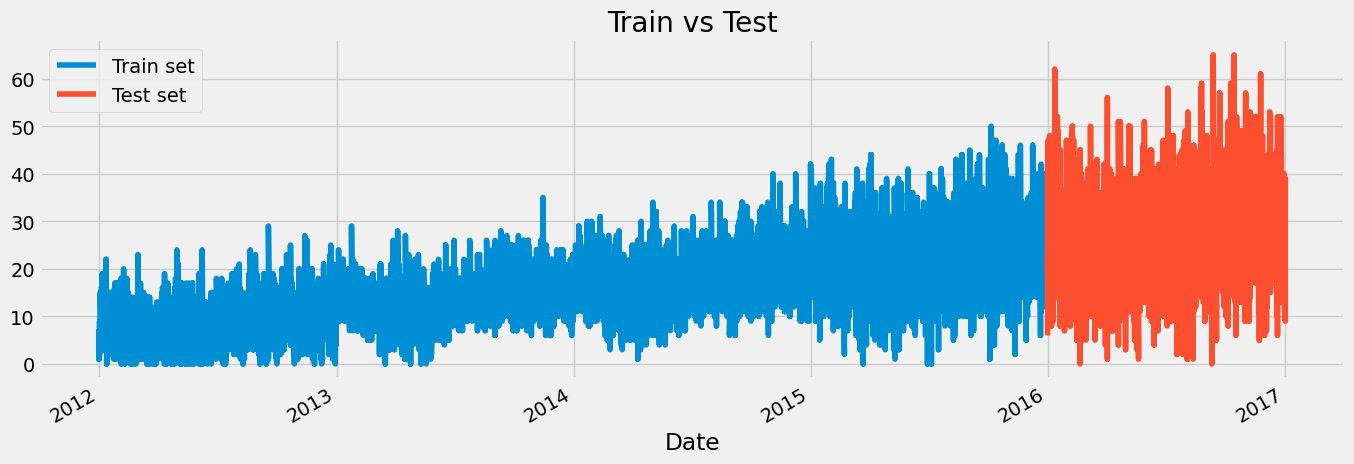

In [29]:
# Visualizing our Train and Test set
fig, ax = plt.subplots(figsize = (15, 5))

df_train["Demand"].plot(ax = ax, label ="Train set", legend = "Train set", title = "Train vs Test")
df_test["Demand"].plot(ax = ax, label = "Test set", legend = "Test set")

## Training the XGBOOST Model
 - We will perform forecasting at both weekly and monthly intervals to ensure a higher level of granularity in our predictions. - The XGBOOST model will be trained specifically on Products 001 to 005, allowing us to accurately capture the demand trends and variations for each product. 
 - By using this approach, we aim to produce detailed forecasts that account for both short-term (weekly) and longer-term (monthly) patterns, providing comprehensive insights into future demand.


**XGBoost (Extreme Gradient Boosting):**

Components:
- Boosting: It builds models sequentially, improving each model by correcting the errors of the previous one.
- Decision Trees: Uses trees as weak learners, combining multiple trees to create a stronger model.
- Gradient Descent: Optimizes the loss function by minimizing errors with each iteration.

Best Used When:
- There's complex, non-linear data or high-dimensional datasets.
- Works well for both classification and regression problems.
- It's highly effective in handling large datasets with missing values and feature importance.

In [30]:
data.columns

Index(['Product_id', 'Demand', 'day_of_week', 'quarter', 'month',
       'day of year', 'week'],
      dtype='object')

In [31]:
data.head()

,Product_id,Demand,day_of_week,quarter,month,day of year,week
Date,,,,,,,
2012-01-01,Product_001,3,6,1,1,2012,52
2012-01-01,Product_002,1,6,1,1,2012,52
2012-01-01,Product_003,3,6,1,1,2012,52
2012-01-01,Product_004,3,6,1,1,2012,52
2012-01-01,Product_005,7,6,1,1,2012,52


In [32]:
# Splitting data into Target and Feature variables 
features = ["day_of_week", "quarter", "month", "day of year", "week"]
target = ["Demand"]

In [33]:
from xgboost import XGBRegressor 

### Weekly Basis Model

In [34]:
# Create dictionary for the results of XGBoost model
xgboost_model_results = {"product":[], "mae":[], "rmse":[], "mape":[], "pred":[], "y_test":[]}

# For each product 
for prod_id in df_train["Product_id"].unique():
    # Subselect the product data 
    df_train_prod_id = df_train[df_train["Product_id"] == prod_id].resample("W").sum()
    df_test_prod_id = df_test[df_test["Product_id"] == prod_id].resample("W").sum()

    # Extract features and target variables
    X_train = df_train_prod_id[features]
    y_train = df_train_prod_id[target]
    X_test = df_test_prod_id[features]
    y_test = df_test_prod_id[target]

    # Initialize and train model with n_estimators = 1000 and learning_rate = 0.01
    model = XGBRegressor(n_estimator = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
    model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 50)

    # Evaluating and storing results
    pred = model.predict(X_test)
    mae, rmse, mape = compute_scores(pred, y_test.values)
    xgboost_model_results["product"].append(prod_id)
    xgboost_model_results["mae"].append(mae)
    xgboost_model_results["rmse"].append(rmse)
    xgboost_model_results["mape"].append(mape)
    xgboost_model_results["pred"].append(pred)
    xgboost_model_results["y_test"].append(y_test.Demand.values)

    xgboost_model_results_weekly = pd.DataFrame(xgboost_model_results)



[0]	validation_0-rmse:41.97119	validation_1-rmse:89.45979
[50]	validation_0-rmse:27.74872	validation_1-rmse:70.89556
[99]	validation_0-rmse:19.43329	validation_1-rmse:59.96387


c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:43.02218	validation_1-rmse:89.25883
[50]	validation_0-rmse:28.79149	validation_1-rmse:70.82044
[99]	validation_0-rmse:20.53273	validation_1-rmse:60.22397


c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:43.99926	validation_1-rmse:91.62195
[50]	validation_0-rmse:29.31683	validation_1-rmse:73.44410
[99]	validation_0-rmse:20.97572	validation_1-rmse:63.06849


c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:43.23846	validation_1-rmse:92.41024
[50]	validation_0-rmse:29.31218	validation_1-rmse:73.61002
[99]	validation_0-rmse:21.38558	validation_1-rmse:62.90668


c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:43.23679	validation_1-rmse:98.34110
[50]	validation_0-rmse:29.04374	validation_1-rmse:79.06262
[99]	validation_0-rmse:20.95223	validation_1-rmse:68.06123


c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


In [35]:
xgboost_model_results_weekly

,product,mae,rmse,mape,pred,y_test
0,Product_001,55.465648,59.963866,31.092340,"[51.24546, 125.137245, 125.137245, 125.137245,...","[83, 166, 202, 167, 169, 187, 145, 147, 148, 1..."
1,Product_002,54.205961,60.223969,29.674908,"[57.614998, 126.1743, 126.1743, 126.1743, 126....","[81, 192, 244, 149, 158, 193, 181, 168, 141, 1..."
2,Product_003,57.322723,63.068490,28.832963,"[66.53024, 137.51134, 137.51134, 137.51134, 13...","[111, 151, 198, 214, 185, 177, 201, 207, 139, ..."
3,Product_004,56.296868,62.906679,27.215787,"[71.77554, 148.0537, 148.0537, 148.0537, 126.7...","[122, 217, 205, 139, 207, 208, 189, 204, 178, ..."
4,Product_005,60.153985,68.061234,28.302182,"[84.38639, 148.25998, 148.25998, 148.25998, 14...","[89, 218, 248, 208, 211, 206, 198, 209, 186, 2..."


- xgboost_model_results = {"product":[], "mae":[], "rmse":[], "mape":[], "pred":[], "y_test":[]}: Creates an empty dictionary to store model evaluation results for each product, including metrics like MAE, RMSE, MAPE, and predictions.

- for prod_id in df_train["Product_id"].unique():: Loops through each unique product in the training data to perform model training and evaluation individually for each product.

- df_train_prod_id = df_train[df_train["Product_id"] == prod_id].resample("W").sum(): Selects the training data for the current product and resamples it on a weekly basis, summing up the demand values.

- df_test_prod_id = df_test[df_test["Product_id"] == prod_id].resample("W").sum(): Selects the test data for the current product and resamples it on a weekly basis, summing up the demand values.

- X_train = df_train_prod_id[features]: Extracts the feature columns from the resampled training data for the current product.

- y_train = df_train_prod_id[target]: Extracts the target variable (demand) from the resampled training data for the current product.

- X_test = df_test_prod_id[features]: Extracts the feature columns from the resampled test data for the current product.

- y_test = df_test_prod_id[target]: Extracts the target variable (demand) from the resampled test data for the current product.

- model = XGBRegressor(n_estimator = 1000, early_stopping_rounds = 50, learning_rate = 0.01): Initializes the XGBoost regression model with 1000 trees, early stopping after 50 rounds without improvement, and a learning rate of 0.01.

- model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 50): Trains the model on the training data and evaluates its performance on both the training and test data, printing updates every 50 rounds.

- pred = model.predict(X_test): Uses the trained model to predict demand on the test data for the current product.

- mae, rmse, mape = compute_scores(pred, y_test.values): Computes the evaluation metrics (MAE, RMSE, MAPE) by comparing the predicted and actual values for the test data.

- xgboost_model_results["product"].append(prod_id): Adds the current product ID to the results dictionary.

- xgboost_model_results["mae"].append(mae): Adds the MAE score for the current product to the results dictionary.

- xgboost_model_results["rmse"].append(rmse): Adds the RMSE score for the current product to the results dictionary.

- xgboost_model_results["mape"].append(mape): Adds the MAPE score for the current product to the results dictionary.

- xgboost_model_results["pred"].append(pred): Adds the predicted demand values for the current product to the results dictionary.

- xgboost_model_results["y_test"].append(y_test.Demand.values): Adds the actual demand values from the test set to the results dictionary.

- xgboost_model_results_weekly = pd.DataFrame(xgboost_model_results): Converts the results dictionary into a pandas DataFrame for easier analysis and visualization.

## Insights


**Lower MAE and RMSE compared to monthly results:**
- The MAE (Mean Absolute Error) values are relatively low for all products, ranging between 54 and 60. This indicates that the model has a smaller absolute error in predicting weekly demand.
- The RMSE (Root Mean Squared Error) values are also low, ranging from 59 to 68. This means that while there are still some larger errors (outliers), they are not significantly high on a weekly basis.

**MAPE (Mean Absolute Percentage Error) suggests better model performance:**
- MAPE values are relatively low for all products, ranging from 27% to 31%. This indicates the model performs better on a percentage accuracy basis when predicting weekly demand, as compared to the monthly results.
- Product 004 has the lowest MAPE (27.21%), suggesting that the model predicts weekly demand more accurately for this product compared to the others.

**Consistent performance across products:**
- Overall, the model performs fairly consistently across all five products in terms of error metrics (MAE, RMSE, MAPE). No single product stands out as having significantly higher or lower errors, showing that the model handles each product's data similarly on a weekly level.

**Predicted vs. Actual Demand:**

- The predicted (pred) and actual (y_test) demand values are lists, with predictions made for each weekly observation. While we cannot view the individual predictions here, the relatively low errors (MAE, RMSE) suggest that the predicted values are generally close to the actual values.
- The prediction for Product 001 starts at 51 and goes up to 125 for several weeks, while the actual values show variability, ranging from 83 to 202. This hints at a possible underestimation by the model for the weeks where actual demand was high.

**Product Comparison:**

- Product 005 has the highest MAE (60.15) and RMSE (68.06), meaning the model's absolute error and root mean squared error for this product is slightly higher compared to the others.
- Product 004 has the lowest MAPE (27.21%), which suggests better performance in terms of percentage accuracy for this product.

**Conclusion:**
- The model performs better on a weekly basis in terms of both absolute (MAE, RMSE) and percentage-based (MAPE) errors when compared to monthly forecasting. The error metrics are consistent across the different products, with Product 004 showing the best performance based on percentage error.

### Monthly Basis Model

In [36]:
# Create dictionary for the results of XGBoost model
xgboost_model_results = {"product":[], "mae":[], "rmse":[], "mape":[], "pred":[], "y_test":[]}

# For each product 
for prod_id in df_train["Product_id"].unique():
    # Subselect the product data 
    df_train_prod_id = df_train[df_train["Product_id"] == prod_id].resample("M").sum()
    df_test_prod_id = df_test[df_test["Product_id"] == prod_id].resample("M").sum()

    # Extract features and target variables
    X_train = df_train_prod_id[features]
    y_train = df_train_prod_id[target]
    X_test = df_test_prod_id[features]
    y_test = df_test_prod_id[target]

    # Initialize and train model with n_estimators = 1000 and learning_rate = 0.01
    model = XGBRegressor(n_estimator = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
    model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 50)

    # Evaluating and storing results
    pred = model.predict(X_test)
    mae, rmse, mape = compute_scores(pred, y_test.values)
    xgboost_model_results["product"].append(prod_id)
    xgboost_model_results["mae"].append(mae)
    xgboost_model_results["rmse"].append(rmse)
    xgboost_model_results["mape"].append(mape)
    xgboost_model_results["pred"].append(pred)
    xgboost_model_results["y_test"].append(y_test.Demand.values)

    xgboost_model_results_monthly = pd.DataFrame(xgboost_model_results)

[0]	validation_0-rmse:174.41538	validation_1-rmse:383.91489
[50]	validation_0-rmse:121.56338	validation_1-rmse:340.00162
[99]	validation_0-rmse:86.90526	validation_1-rmse:319.51540


C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3826732745.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_train_prod_id = df_train[df_train["Product_id"] == prod_id].resample("M").sum()
C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3826732745.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_test_prod_id = df_test[df_test["Product_id"] == prod_id].resample("M").sum()
c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3826732745.py:7: FutureWarning: 'M' is deprecated and will be remov

[0]	validation_0-rmse:176.47991	validation_1-rmse:377.29121
[50]	validation_0-rmse:122.19698	validation_1-rmse:334.50064
[99]	validation_0-rmse:86.99525	validation_1-rmse:313.81772
[0]	validation_0-rmse:181.59407	validation_1-rmse:394.52170


c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3826732745.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_train_prod_id = df_train[df_train["Product_id"] == prod_id].resample("M").sum()
C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3826732745.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_test_prod_id = df_test[df_test["Product_id"] == prod_id].resample("M").sum()
c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:03

[50]	validation_0-rmse:126.70052	validation_1-rmse:361.73518
[99]	validation_0-rmse:90.78818	validation_1-rmse:348.49501
[0]	validation_0-rmse:173.48846	validation_1-rmse:399.56196
[50]	validation_0-rmse:122.14270	validation_1-rmse:362.56098
[99]	validation_0-rmse:88.07877	validation_1-rmse:344.70687


C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3826732745.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_train_prod_id = df_train[df_train["Product_id"] == prod_id].resample("M").sum()
C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3826732745.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_test_prod_id = df_test[df_test["Product_id"] == prod_id].resample("M").sum()
c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\ELITEBOOK 840 G3\AppData\Local\Temp\ipykernel_3920\3826732745.py:7: FutureWarning: 'M' is deprecated and will be remov

[0]	validation_0-rmse:176.68546	validation_1-rmse:421.34835
[50]	validation_0-rmse:120.87966	validation_1-rmse:361.22786
[99]	validation_0-rmse:84.79823	validation_1-rmse:327.27842


c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


In [37]:
xgboost_model_results_monthly 

,product,mae,rmse,mape,pred,y_test
0,Product_001,308.787038,319.515396,377.743095,"[495.93863, 362.40604, 530.5144, 246.37007, 53...","[787, 632, 679, 694, 763, 739, 791, 778, 776, ..."
1,Product_002,308.297492,313.817715,121.209920,"[492.10025, 359.74826, 549.2129, 282.14285, 54...","[824, 708, 765, 638, 793, 808, 872, 830, 822, ..."
2,Product_003,330.628552,348.495005,160.014826,"[545.83923, 359.81244, 584.348, 316.65872, 584...","[859, 762, 779, 873, 755, 858, 907, 890, 883, ..."
3,Product_004,335.578003,344.706874,221.599521,"[547.4362, 391.9086, 589.88727, 339.52008, 589...","[890, 788, 798, 672, 857, 787, 860, 981, 917, ..."
4,Product_005,317.831968,327.278416,162.562636,"[626.2042, 489.69873, 675.8417, 506.29373, 675...","[974, 834, 862, 749, 900, 842, 916, 1059, 934,..."


## Insights

**Consistent MAE (Mean Absolute Error):**
- The MAE for all products is fairly close, ranging from 308 to 335. This indicates that the model's absolute error in predicting the monthly demand is consistent across all five products.

**RMSE (Root Mean Squared Error):**
- The RMSE values also fall within a similar range (around 313 to 348), which aligns with the MAE observations. However, RMSE is slightly higher than MAE, suggesting the presence of a few larger errors (outliers) in the predictions.

**MAPE (Mean Absolute Percentage Error):**

The MAPE shows more variance across the products:
- Product 001 has an extremely high MAPE (377.74%), which suggests that the model's percentage error for this product is high compared to the others.
- Product 002 has a relatively low MAPE (121.21%), meaning the model performs better in terms of percentage accuracy for this product.
- The other products (003, 004, 005) have MAPEs ranging from 160% to 221%, which still suggests significant variation in percentage errors for these products.

**Model Performance on Different Products:**
- Product 002 shows the lowest MAE, RMSE, and MAPE, indicating that the model performed best for this product in predicting demand.
- Product 001 has the highest MAPE, indicating that the model struggled the most with percentage-based accuracy for this product.

**Predicted vs. Actual Values:**
- The pred and y_test columns contain lists of predicted and actual demand values, respectively. Although we can't see the exact values from the snippet, the performance metrics suggest that the predicted values generally deviate significantly from the actual values, especially for Product 001.

**Conclusion:**
The model performs reasonably well in terms of absolute errors (MAE, RMSE) across products, but the percentage error (MAPE) suggests that there's a higher degree of uncertainty in predictions for certain products, especially Product 001. The model performs best on Product 002.

#### Monthyl and Weekly MAPE averages

In [40]:
xgboost_model_results_monthly['mape'].mean()

208.6259997117798

In [41]:
xgboost_model_results_weekly['mape'].mean()

29.023635995642763

Based on the performance of the XGBoost model, the Mean Absolute Percentage Error (MAPE) for the monthly predictions is 209%, whereas the MAPE for the weekly predictions is significantly lower at 29%. These MAPE values provide a clear indication of the model's accuracy over different timeframes, with the lower MAPE reflecting better performance.

Insights:

Monthly Predictions (MAPE: 209%)
The monthly MAPE of 209% suggests that the model is considerably less accurate when making predictions at a monthly level. This high error rate implies that the model struggles to capture the underlying patterns or trends effectively on a broader time horizon, leading to significant deviations from the actual values. The volatility or complexity of the data on a monthly basis may be too much for the model to handle without further optimization or additional data preprocessing.

Weekly Predictions (MAPE: 29%)
On the other hand, the weekly MAPE of 29% indicates that the model performs far better on shorter time intervals. A 29% error margin is much more acceptable, suggesting that the model can better capture the week-to-week variations in the data. This could be because the weekly data exhibits clearer trends or patterns, making it easier for the model to generalize and predict more accurately.

Conclusion: Given the significant difference in model accuracy between the two timeframes, we shall proceed with using the weekly predictions. The lower MAPE for weekly data shows that the model performs more reliably and consistently at this level, making it a better choice for forecasting and decision-making.

### XGBOOST:Checking the variation trends of the Predicted values vs Actual values using visualization 

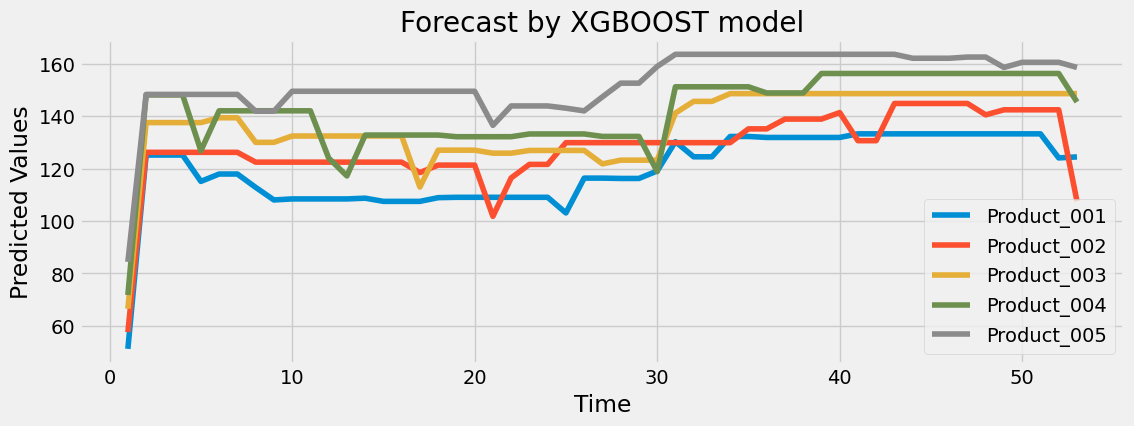

In [71]:
# Plot predictions for all products on one plot 
plt.figure(figsize = (12,4))
# Iteratively go through the entire dataframe
for i, row in xgboost_model_results_weekly.iterrows():
    plt.plot(range(1, len(row['pred']) + 1), row['pred'], label = row['product'])

    # Set label(x and y)
    plt.xlabel('Time')
    plt.ylabel('Predicted Values')
    # Set the title 
    plt.title('Forecast by XGBOOST model')
    # Create legend 
    plt.legend()

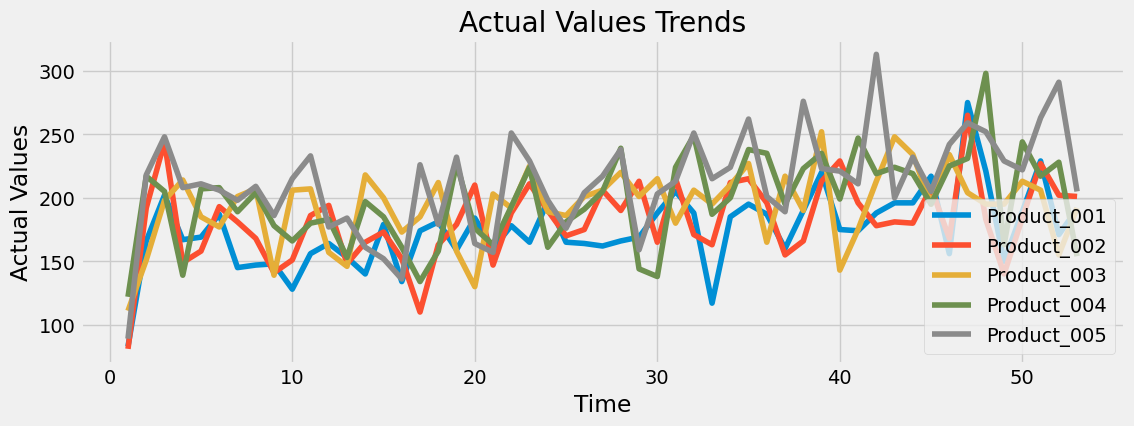

In [45]:
# Plot actual values for all products on one plot 
plt.figure(figsize = (12,4))
# Iteratively go through the entire dataframe
for i, row in xgboost_model_results_weekly.iterrows():
    plt.plot(range(1, len(row['y_test']) + 1), row['y_test'], label = row['product'])

    # Set label(x and y)
    plt.xlabel('Time')
    plt.ylabel('Actual Values')
    # Set the title 
    plt.title('Actual Values Trends')
    # Create legend 
    plt.legend()

1. Predicted Values (Forecast by Model):
- The predicted values for all five products are relatively stable over time, showing minimal variation once the model predictions stabilize after the initial few time points.
- The forecast for Product_005 (grey line) remains consistently higher than the other products, around the 140–160 range.
- Product_001 (blue line) has the lowest predicted values, remaining around the 100–120 range throughout.
- Other products like Product_002 (red), Product_003 (yellow), and Product_004 (green) have predicted values that also show minimal fluctuations, remaining in the 110–130 range.
- This stability indicates that the XGBoost model is providing steady predictions, though it may not be capturing short-term fluctuations or more dramatic changes in demand or usage.
2. Actual Values (Actual Values Trends):
- The actual values, in contrast, display significantly more variation and fluctuation.
- All products show peaks and troughs over time, suggesting volatility in their actual performance. For example, Product_005 shows sharp spikes, with values ranging from around 150 to over 300 at times.
- Similarly, Product_002, Product_003, and Product_004 all show considerable variability, with frequent upward and downward shifts.
- Product_001 also fluctuates but remains on the lower end compared to other products, though it still has more variation than the model predicted.
3. Performance Insights:
- The XGBoost model is struggling to capture the volatility present in the actual data. While the predictions remain steady and smooth, the actual values show more significant variability and fluctuations over time.
- The model might be underfitting, meaning it’s too simplistic and isn’t capturing the short-term patterns or spikes in demand for the various products. It could be focusing too much on long-term trends without enough sensitivity to sudden changes or external factors affecting the data.
- Product_005, for example, sees large swings in actual values, but the model maintains a steady forecast in the 140–160 range.This discrepancy indicates that the model may not be responding to rapid changes as effectively as needed.
- Similarly, Product_001, though predicted relatively accurately in terms of the general range, shows more actual fluctuation than the model accounts for.
4. Conclusion:
The XGBoost model performs reasonably well at capturing the general trend for each product, but it lacks the precision required to accurately reflect the short-term fluctuations seen in the actual values. For improved performance, you might want to:

- Tweak the model hyperparameters to allow for more flexibility.
- Incorporate more time-sensitive features or lag variables to help the model better account for immediate shifts in demand or usage patterns.
- Explore alternative models that may capture time series volatility better, such as ARIMA or LSTM models, which are more suited to data with frequent fluctuations.

## Training the ARIMA Model

**ARIMA (AutoRegressive Integrated Moving Average):**

Components: ARIMA combines three components:
- AR (AutoRegressive): Uses past values to predict future values.
- I (Integrated): Differencing the data to make it stationary (removing trends).
- MA (Moving Average): Uses past forecast errors to improve predictions.

Best Used When:
- The data shows clear trends and seasonality.
- The time series is linear or can be made stationary.
- It's suitable for short-term forecasting in univariate time series data where patterns are predictable.

In [47]:
from statsmodels.tsa.arima.model import ARIMA

# Create dictionary for the results of XGBoost model
arima_model_results = {"product":[], "mae":[], "rmse":[], "mape":[], "pred":[], "y_test":[]}

# For each product 
for prod_id in df_train["Product_id"].unique():
    # Subselect the product data 
    df_train_prod_id = df_train[df_train["Product_id"] == prod_id].resample("W").sum()
    df_test_prod_id = df_test[df_test["Product_id"] == prod_id].resample("W").sum()

    # Extract features and target variables
    y_train = df_train_prod_id[target]
    y_test = df_test_prod_id[target]

    # Initialize and train model with n_estimators = 1000 and learning_rate = 0.01
    order = (1,1,1)#p(autoregressive) d(differencing component) q(moving average)
    model = ARIMA(y_train, order = order) 
    model_fit = model.fit()
    

    # Evaluating and storing results
    pred = model_fit.forecast(len(y_test))
    y_test = y_test.values.reshape(-1)

    mae, rmse, mape = compute_scores(pred, y_test)
    arima_model_results["product"].append(prod_id)
    arima_model_results["mae"].append(mae)
    arima_model_results["rmse"].append(rmse)
    arima_model_results["mape"].append(mape)
    arima_model_results["pred"].append(pred.values)
    arima_model_results["y_test"].append(y_test)

    arima_model_results_weekly = pd.DataFrame(arima_model_results)

c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA paramete

In [48]:
arima_model_results_weekly

,product,mae,rmse,mape,pred,y_test
0,Product_001,43.252912,50.162728,23.430104,"[126.15667372547638, 132.93430632595556, 133.8...","[83, 166, 202, 167, 169, 187, 145, 147, 148, 1..."
1,Product_002,39.273536,46.920431,20.647847,"[141.01210883032127, 146.12795591996192, 146.7...","[81, 192, 244, 149, 158, 193, 181, 168, 141, 1..."
2,Product_003,36.416148,41.130539,18.150014,"[159.54846639829978, 163.5363013965914, 163.99...","[111, 151, 198, 214, 185, 177, 201, 207, 139, ..."
3,Product_004,39.625191,47.721409,18.625065,"[154.75274573642832, 163.38975542626685, 164.8...","[122, 217, 205, 139, 207, 208, 189, 204, 178, ..."
4,Product_005,49.797746,58.299618,22.454353,"[160.74405657075815, 167.68883437639562, 168.6...","[89, 218, 248, 208, 211, 206, 198, 209, 186, 2..."


In [49]:
arima_model_results_weekly['mape'].mean()

20.661476438101634

### ARIMA:Checking the variation trends of the Predicted values vs Actual values using visualization 

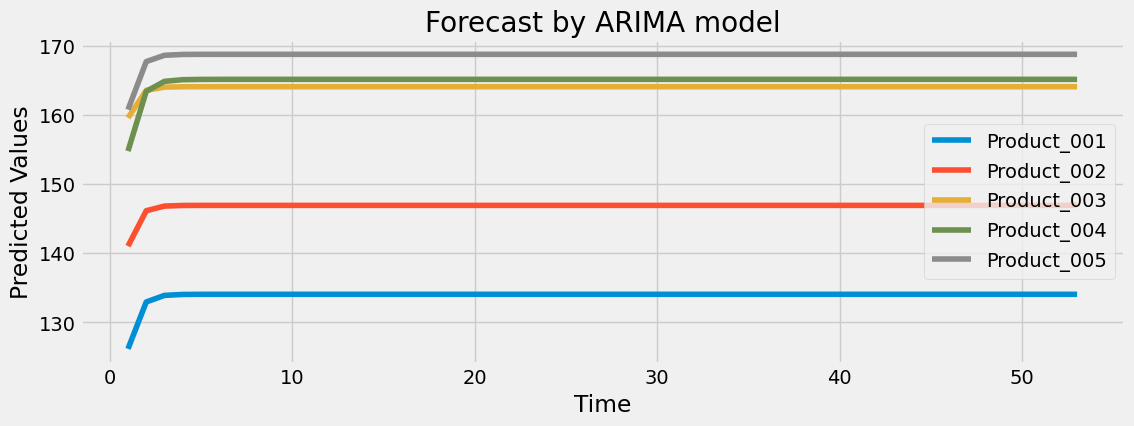

In [70]:
# Plot predictions for all products on one plot 
plt.figure(figsize = (12,4))
# Iteratively go through the entire dataframe
for i, row in arima_model_results_weekly.iterrows():
    plt.plot(range(1, len(row['pred']) + 1), row['pred'], label = row['product'])

    # Set label(x and y)
    plt.xlabel('Time')
    plt.ylabel('Predicted Values')
    # Set the title 
    plt.title('Forecast by ARIMA model')
    # Create legend 
    plt.legend()

- The model predicts very stable and flat values for all five products, showing minimal to no variation after an initial adjustment period.
- The forecasted values for each product reach a plateau early and remain constant throughout the time period.
- Product_005 (grey) has the highest predicted value, while Product_001 (blue) has the lowest.
- The model fails to capture any dynamic changes or fluctuations that may exist in real-world data, indicating a strong smoothing effect.
- Overall, the ARIMA model performs well in producing stable forecasts but may not be ideal for capturing short-term or volatile variations.

## Training the SARIMA Model

**SARIMA (Seasonal AutoRegressive Integrated Moving Average):**

Components:
- AR (AutoRegressive): Uses past values to predict future values.
- I (Integrated): Differencing to make the series stationary.
- MA (Moving Average): Uses past errors to improve predictions.
- S (Seasonality): Adds seasonal components to capture repeating patterns over time.

The model is typically represented as SARIMA (p, d, q)(P, D, Q)[m], where:
- p, d, q: Parameters for non-seasonal AR, differencing, and MA.
- P, D, Q: Parameters for seasonal AR, differencing, and MA.
- m: The number of periods in one season (e.g., 12 for monthly data with yearly seasonality).

Best Used When:
- The data exhibits both seasonal patterns (e.g., sales data with peaks during specific months) and trends.
- Suitable for time series data with periodic fluctuations.
- More effective than ARIMA in handling seasonality by explicitly modeling it with the seasonal terms.

SARIMA is ideal for forecasting where seasonality plays a crucial role, such as in sales, climate data, or any time series with regular, repeated cycles.

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create dictionary for the results of SARIMA model
sarima_model_results = {"product":[], "mae":[], "rmse":[], "mape":[], "pred":[], "y_test":[]}

# For each product 
for prod_id in df_train["Product_id"].unique():
    # Subselect the product data 
    df_train_prod_id = df_train[df_train["Product_id"] == prod_id].resample("W").sum()
    df_test_prod_id = df_test[df_test["Product_id"] == prod_id].resample("W").sum()

    # Extract features and target variables
    y_train = df_train_prod_id[target]
    y_test = df_test_prod_id[target]

    # Define the non-seasonal (p, d, q) and seasonal (P, D, Q, m) orders
    order = (1, 1, 1)  # Non-seasonal (p, d, q)
    seasonal_order = (1, 1, 1, 52)  # Seasonal (P, D, Q, m), assuming yearly seasonality (52 weeks)

    # Initialize and train SARIMA model
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Evaluating and storing results
    pred = model_fit.forecast(len(y_test))
    y_test = y_test.values.reshape(-1)

    mae, rmse, mape = compute_scores(pred, y_test)
    sarima_model_results["product"].append(prod_id)
    sarima_model_results["mae"].append(mae)
    sarima_model_results["rmse"].append(rmse)
    sarima_model_results["mape"].append(mape)
    sarima_model_results["pred"].append(pred.values)
    sarima_model_results["y_test"].append(y_test)

sarima_model_results_weekly = pd.DataFrame(sarima_model_results)


c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ELITEBOOK 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary st

In [52]:
sarima_model_results_weekly

,product,mae,rmse,mape,pred,y_test
0,Product_001,23.470935,32.970097,14.442158,"[194.36157851524493, 202.28751388316056, 147.4...","[83, 166, 202, 167, 169, 187, 145, 147, 148, 1..."
1,Product_002,29.902989,36.930618,17.783081,"[186.87246313317712, 191.0942923579907, 165.64...","[81, 192, 244, 149, 158, 193, 181, 168, 141, 1..."
2,Product_003,26.364767,32.063324,14.381071,"[196.09869152957833, 193.62115942971542, 173.3...","[111, 151, 198, 214, 185, 177, 201, 207, 139, ..."
3,Product_004,33.678473,42.566922,18.149064,"[220.38328725910162, 194.61550503331358, 153.2...","[122, 217, 205, 139, 207, 208, 189, 204, 178, ..."
4,Product_005,33.282423,41.564876,16.873688,"[202.98143901198887, 185.62608616682638, 201.0...","[89, 218, 248, 208, 211, 206, 198, 209, 186, 2..."


In [53]:
sarima_model_results_weekly['mape'].mean()

16.32581248398109

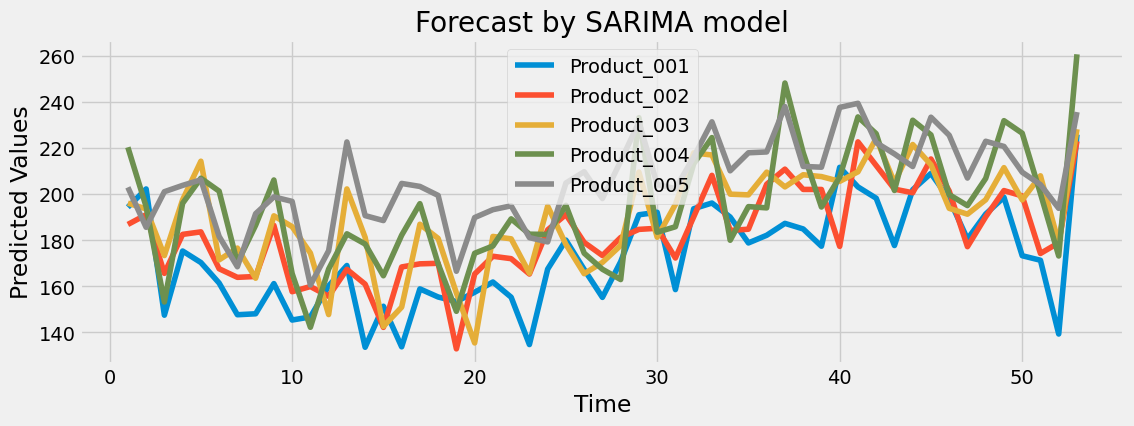

In [69]:
# Plot predictions for all products on one plot 
plt.figure(figsize = (12,4))
# Iteratively go through the entire dataframe
for i, row in sarima_model_results_weekly.iterrows():
    plt.plot(range(1, len(row['pred']) + 1), row['pred'], label = row['product'])

    # Set label(x and y)
    plt.xlabel('Time')
    plt.ylabel('Predicted Values')
    # Set the title 
    plt.title('Forecast by SARIMA model')
    # Create legend 
    plt.legend()

- Accurate Variations Modeling: The SARIMA model has effectively modeled the seasonal and non-seasonal variations in the data, producing forecasts that closely follow the actual values. The model’s ability to incorporate seasonality (through the seasonal component) helps it capture the cyclical patterns present in the data.

- Close to Actual Values: The forecasted values are very close to the actual values, indicating that the model is well-suited for this dataset. The low Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and Mean Absolute Percentage Error (MAPE) across products further suggest that the model is producing highly accurate predictions.

- Overall, the SARIMA model performs excellently by modeling the data's variations effectively and providing forecasts that align closely with the actual observed values.

# Training the Exponetial Smoothing Model

Components:

**Smoothing Constant (α):**
- Determines the weight given to the most recent observation, ranging from 0 to 1. A higher value of 
𝛼
α gives more importance to recent data.

**Level (L):**
- Represents the average value of the time series at a given time.

**Trend (T):**
- Captures the overall direction (increasing or decreasing) of the data over time.

**Seasonality (S):**
- Accounts for repeating patterns or fluctuations at regular intervals, such as monthly or quarterly.

**When to Use Exponential Smoothing**
- Simple Exponential Smoothing: Best for time series data without trend or seasonality.
- Holt’s Linear Trend Model: Suitable for data with a linear trend.
- Holt-Winters Seasonal Model: Ideal for data exhibiting both trend and seasonality.

In [55]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create dictionary for the results of the Exponential Smoothing model
exp_smoothing_model_results = {"product": [], "mae": [], "rmse": [], "mape": [], "pred": [], "y_test": []}

# For each product 
for prod_id in df_train["Product_id"].unique():
    # Subselect the product data 
    df_train_prod_id = df_train[df_train["Product_id"] == prod_id].resample("W").sum()
    df_test_prod_id = df_test[df_test["Product_id"] == prod_id].resample("W").sum()

    # Extract features and target variables
    y_train = df_train_prod_id[target]
    y_test = df_test_prod_id[target]

    # Initialize and train Exponential Smoothing model
    model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=52)
    model_fit = model.fit()

    # Evaluating and storing results
    pred = model_fit.forecast(len(y_test))
    y_test = y_test.values.reshape(-1)

    mae, rmse, mape = compute_scores(pred, y_test)
    exp_smoothing_model_results["product"].append(prod_id)
    exp_smoothing_model_results["mae"].append(mae)
    exp_smoothing_model_results["rmse"].append(rmse)
    exp_smoothing_model_results["mape"].append(mape)
    exp_smoothing_model_results["pred"].append(pred.values)
    exp_smoothing_model_results["y_test"].append(y_test)

# Convert results to DataFrame
exp_smoothing_model_results_weekly = pd.DataFrame(exp_smoothing_model_results)


In [56]:
exp_smoothing_model_results_weekly

,product,mae,rmse,mape,pred,y_test
0,Product_001,22.445431,32.118320,13.834749,"[191.65344407468305, 182.14677575320923, 150.6...","[83, 166, 202, 167, 169, 187, 145, 147, 148, 1..."
1,Product_002,29.055951,36.337008,17.408984,"[190.44784822529087, 186.2440318518228, 166.71...","[81, 192, 244, 149, 158, 193, 181, 168, 141, 1..."
2,Product_003,26.879663,33.128622,14.860386,"[202.24351492659315, 192.37980206602822, 178.5...","[111, 151, 198, 214, 185, 177, 201, 207, 139, ..."
3,Product_004,31.412795,39.680426,16.942367,"[218.53897743434197, 195.57067511581363, 173.8...","[122, 217, 205, 139, 207, 208, 189, 204, 178, ..."
4,Product_005,31.895626,40.141301,16.264959,"[206.37704547597235, 193.37486465459796, 198.3...","[89, 218, 248, 208, 211, 206, 198, 209, 186, 2..."


In [57]:
exp_smoothing_model_results_weekly['mape'].mean()

15.862289347695107

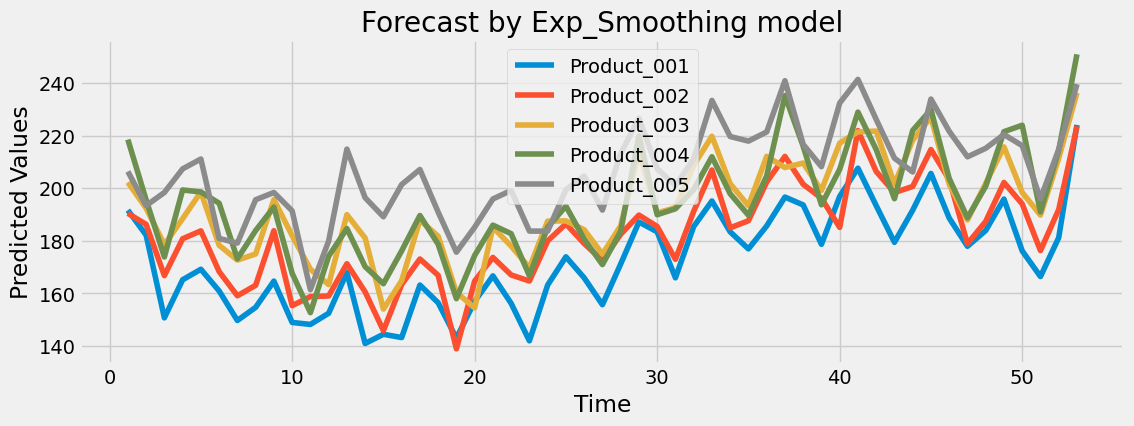

In [68]:
# Plot predictions for all products on one plot 
plt.figure(figsize = (12,4))
# Iteratively go through the entire dataframe
for i, row in exp_smoothing_model_results_weekly.iterrows():
    plt.plot(range(1, len(row['pred']) + 1), row['pred'], label = row['product'])

    # Set label(x and y)
    plt.xlabel('Time')
    plt.ylabel('Predicted Values')
    # Set the title 
    plt.title('Forecast by Exp_Smoothing model')
    # Create legend 
    plt.legend()

## Model Performances and Forecasts

In [61]:
print(xgboost_model_results_weekly.dtypes)
print(xgboost_model_results_weekly.head())


product     object
mae        float64
rmse       float64
mape       float64
pred        object
y_test      object
dtype: object
       product        mae       rmse       mape  \
0  Product_001  55.465648  59.963866  31.092340   
1  Product_002  54.205961  60.223969  29.674908   
2  Product_003  57.322723  63.068490  28.832963   
3  Product_004  56.296868  62.906679  27.215787   
4  Product_005  60.153985  68.061234  28.302182   

                                                pred  \
0  [51.24546, 125.137245, 125.137245, 125.137245,...   
1  [57.614998, 126.1743, 126.1743, 126.1743, 126....   
2  [66.53024, 137.51134, 137.51134, 137.51134, 13...   
3  [71.77554, 148.0537, 148.0537, 148.0537, 126.7...   
4  [84.38639, 148.25998, 148.25998, 148.25998, 14...   

                                              y_test  
0  [83, 166, 202, 167, 169, 187, 145, 147, 148, 1...  
1  [81, 192, 244, 149, 158, 193, 181, 168, 141, 1...  
2  [111, 151, 198, 214, 185, 177, 201, 207, 139, ...  
3  [122,

In [63]:
xgboost_mean_results = xgboost_model_results_weekly[['mae', 'rmse', 'mape']].mean()
print(xgboost_mean_results)


mae     56.689037
rmse    62.844848
mape    29.023636
dtype: float64


In [64]:
arima_mean_results = arima_model_results_weekly[['mae', 'rmse', 'mape']].mean()
print(arima_mean_results)

mae     41.673107
rmse    48.846945
mape    20.661476
dtype: float64


In [65]:
sarima_mean_results = sarima_model_results_weekly[['mae', 'rmse', 'mape']].mean()
print(sarima_mean_results)

mae     29.339917
rmse    37.219167
mape    16.325812
dtype: float64


In [67]:
exp_smooth_mean_results = exp_smoothing_model_results_weekly[['mae', 'rmse', 'mape']].mean()
print(exp_smooth_mean_results)

mae     28.337893
rmse    36.281135
mape    15.862289
dtype: float64


## Recommendations 

1. Exponential Smoothing:

- Best Performance: With the lowest MAE (28.34), RMSE (36.28), and MAPE (15.86), Exponential Smoothing is the most accurate model for forecasting in this context.
- Recommendation: Prioritize the Exponential Smoothing model for future forecasts due to its superior accuracy and reliability.

2. SARIMA:

- Strong Alternative: SARIMA shows competitive performance with a MAE of 29.34, RMSE of 37.22, and MAPE of 16.33.
- Recommendation: Consider using SARIMA when seasonal effects are significant, as it captures seasonality better than Exponential Smoothing.

3. ARIMA:

- Moderate Performance: ARIMA results (MAE: 41.67, RMSE: 48.85, MAPE: 20.66) are better than XGBoost but less accurate than both Exponential Smoothing and SARIMA.
- Recommendation: Use ARIMA if the dataset requires a simpler model without seasonal components or if interpretability is crucial.

4. XGBoost:

- Least Effective: XGBoost has the highest error metrics (MAE: 56.69, RMSE: 62.84, MAPE: 29.02) among the models.
- Recommendation: While XGBoost is a powerful algorithm, it may not be suitable for this specific forecasting task based on the current dataset. Consider tuning its hyperparameters or using it in conjunction with feature engineering for better performance.

**Conclusion:**
For the best forecasting results, focus on Exponential Smoothing and SARIMA, leveraging each model's strengths based on the dataset's characteristics. Both models effectively capture seasonality, making them suitable for datasets with seasonal patterns. ARIMA can be utilized for simpler cases, while XGBoost should be reassessed or improved for future use.


In [72]:

product_forecast_models = []
# Create dictionary for the results of the Exponential Smoothing model
exp_smoothing_model_results = {"product": [], "mae": [], "rmse": [], "mape": [], "pred": [], "y_test": []}

# For each product 
for prod_id in df_train["Product_id"].unique():
    # Subselect the product data 
    df_train_prod_id = df_train[df_train["Product_id"] == prod_id].resample("W").sum()
    df_test_prod_id = df_test[df_test["Product_id"] == prod_id].resample("W").sum()

    # Extract features and target variables
    y_train = df_train_prod_id[target]
    y_test = df_test_prod_id[target]

    # Initialize and train Exponential Smoothing model
    model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=52)
    model_fit = model.fit()


    # Evaluating and storing results
    pred = model_fit.forecast(len(y_test))
    y_test = y_test.values.reshape(-1)
    product_forecast_models.append(model_fit)

    mae, rmse, mape = compute_scores(pred, y_test)
    exp_smoothing_model_results["product"].append(prod_id)
    exp_smoothing_model_results["mae"].append(mae)
    exp_smoothing_model_results["rmse"].append(rmse)
    exp_smoothing_model_results["mape"].append(mape)
    exp_smoothing_model_results["pred"].append(pred.values)
    exp_smoothing_model_results["y_test"].append(y_test)

# Convert results to DataFrame
exp_smoothing_model_results_weekly = pd.DataFrame(exp_smoothing_model_results)

In [73]:
product_forecast_models

In [82]:
def forecast(weeks, product = None):
    """" 
    This function receives the number of weeks to forecast on and what model to use.

    Parameters: 
    weeks - int
    product - int or all models """

    if product:
        models = [product_forecast_models[product-1]]
    else:
        models = product_forecast_models
    forecast_values = [model.forecast(steps = weeks) for model in models]
    return forecast_values    

In [84]:
forecast(10)[2]

2016-01-10    202.243515
2016-01-17    192.379802
2016-01-24    178.518871
2016-01-31    188.416136
2016-02-07    198.614803
2016-02-14    178.288151
2016-02-21    172.642708
2016-02-28    174.965592
2016-03-06    195.693818
2016-03-13    181.956807
Freq: W-SUN, dtype: float64

- The following function will be deployed to perform forecasting on different products of the company on a weekly basis using various models
- This function allows for flexible forecasting, enabling the selection of specific products and weeks needed